In [13]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import seaborn as sns
import matplotlib.pyplot as plt


In [7]:
df_dev = pd.read_csv('../dataset/development.csv')
df_eval = pd.read_csv('../dataset/evaluation.csv')

df = pd.concat([df_dev, df_eval], sort=False)
df.head()

,id,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,...,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares,data_channel,weekday
0,0,http://mashable.com/2014/09/08/safest-cabbies-...,121.0,12.0,1015.0,0.422018,1.0,0.545031,10.0,6.0,...,-0.160714,-0.50,-0.071429,0.0,0.00,0.5,0.00,2900.0,bus,tuesday
1,1,http://mashable.com/2013/07/25/3d-printed-rifle/,532.0,9.0,503.0,0.569697,1.0,0.737542,9.0,0.0,...,-0.157500,-0.25,-0.100000,0.0,0.00,0.5,0.00,1300.0,tech,thursday
2,2,http://mashable.com/2013/10/30/digital-dinosau...,435.0,9.0,232.0,0.646018,1.0,0.748428,12.0,3.0,...,-0.427500,-1.00,-0.187500,0.0,0.00,0.5,0.00,17700.0,lifestyle,wednesday
3,3,http://mashable.com/2014/08/27/homer-simpson-i...,134.0,12.0,171.0,0.722892,1.0,0.867925,9.0,5.0,...,-0.216667,-0.25,-0.166667,0.4,-0.25,0.1,0.25,1500.0,bus,wednesday
4,4,http://mashable.com/2013/01/10/creepy-robotic-...,728.0,11.0,286.0,0.652632,1.0,0.800000,5.0,2.0,...,-0.251786,-0.50,-0.100000,0.2,-0.10,0.3,0.10,1400.0,tech,thursday


In [42]:
def final_preprocessing_eval(df, dev_stats):
    working_df_dev = df.copy()

    for index, row in working_df_dev.iterrows():
        if 'data_channel' in row and not row['num_keywords'] >= 0:
            working_df_dev.at[index, 'num_keywords'] = dev_stats['num_keywords_mean'][row['data_channel']]

    enc = OneHotEncoder()
    encoded_df = pd.concat([df['weekday'], df['data_channel']], axis=1)
    enc.fit(encoded_df)
    encoded_df = enc.transform(encoded_df)
    additional_columns = enc.get_feature_names_out()
    working_df_dev[additional_columns] = encoded_df.toarray()
    working_df_dev.drop(['weekday', 'data_channel', 'url', 'id'], axis = 1, inplace=True)

    working_df_dev['n_tokens_content'] = np.log(1 + working_df_dev['n_tokens_content'])

    std_scaler = dev_stats['kw_scaler']
    scaled_features = std_scaler.transform(working_df_dev[['kw_avg_max', 'kw_avg_avg', 'kw_avg_min', 'kw_min_avg','kw_max_avg', 'kw_max_min', 'kw_min_max']])
    working_df_dev[['kw_avg_max', 'kw_avg_avg', 'kw_avg_min', 'kw_min_avg','kw_max_avg', 'kw_max_min', 'kw_min_max']] = scaled_features

    std_scaler = dev_stats['ref_scaler']
    scaled_features = std_scaler.transform(working_df_dev[['self_reference_min_shares', 'self_reference_max_shares', 'self_reference_avg_sharess']])
    working_df_dev[['self_reference_min_shares', 'self_reference_max_shares', 'self_reference_avg_sharess']] = scaled_features

    std_scaler = dev_stats['scaler_details']
    scaled_features = std_scaler.transform(working_df_dev[['n_tokens_title', 'n_tokens_content']])
    working_df_dev[['n_tokens_title', 'n_tokens_content']] = scaled_features

    working_df_dev['num_imgs'].fillna(dev_stats['num_imgs_mean'], inplace=True)
    working_df_dev['num_imgs'] = np.log(1 + working_df_dev['num_imgs'])

    working_df_dev['num_self_hrefs'].fillna(dev_stats['num_self_hrefs_mean'], inplace=True)
    working_df_dev['num_self_hrefs'] = np.log(1 + working_df_dev['num_self_hrefs'])

    working_df_dev['num_videos'].fillna(dev_stats['num_videos_mean'], inplace=True)
    working_df_dev['num_videos'] = np.log(1 + working_df_dev['num_videos'])

    is_weekend = []
    for _, row in working_df_dev.iterrows():
        if row['weekday_sunday'] == 1 or row['weekday_saturday'] == 1:
            is_weekend.append(1)
        else:
            is_weekend.append(0)
    working_df_dev['is_weekend'] = is_weekend
    working_df_dev.drop(columns=[x for x in additional_columns if x.startswith('weekday')], inplace=True)

    std_scaler = dev_stats['time_scaler']
    scaled_features = std_scaler.transform(working_df_dev[['timedelta']])
    working_df_dev[['timedelta']] = scaled_features

    return working_df_dev

In [43]:
def final_preprocessing_dev(df):
    working_df_dev = df.copy()
    dev_stats = dict()

    working_df_dev['num_keywords'] = df.groupby(['data_channel'], sort=False)['num_keywords'].apply(lambda x: x.fillna(x.mean())).reset_index()['num_keywords']
    dev_stats['num_keywords_mean'] = df.groupby(['data_channel'], sort=False)['num_keywords'].mean()

    enc = OneHotEncoder()
    encoded_df = pd.concat([df['weekday'], df['data_channel']], axis=1)
    enc.fit(encoded_df)
    encoded_df = enc.transform(encoded_df)
    additional_columns = enc.get_feature_names_out()
    working_df_dev[additional_columns] = encoded_df.toarray()
    working_df_dev.drop(['weekday', 'data_channel', 'url', 'id'], axis = 1, inplace=True)



    working_df_dev['n_tokens_content'] = np.log(1 + working_df_dev['n_tokens_content'])

    working_df_dev['shares'] = np.log(working_df_dev['shares'])

    # Remove outliers from kw_avg_avg (we lost another 9% of the dataset)
    q1 = working_df_dev['kw_avg_avg'].describe()['25%']
    q3 = working_df_dev['kw_avg_avg'].describe()['75%']
    iqr = q3 - q1
    min_kw_avg_avg = q1 - 1.5*iqr
    max_kw_avg_avg = q3 + 1.5*iqr
    working_df_dev = working_df_dev[(df.kw_avg_avg < max_kw_avg_avg) & (df.kw_avg_avg > min_kw_avg_avg)]

    std_scaler = StandardScaler().fit(working_df_dev[['kw_avg_max', 'kw_avg_avg', 'kw_avg_min', 'kw_min_avg', 'kw_max_avg', 'kw_max_min', 'kw_min_max']])
    scaled_features = std_scaler.transform(working_df_dev[['kw_avg_max', 'kw_avg_avg', 'kw_avg_min', 'kw_min_avg','kw_max_avg', 'kw_max_min', 'kw_min_max']])
    working_df_dev[['kw_avg_max', 'kw_avg_avg', 'kw_avg_min', 'kw_min_avg','kw_max_avg', 'kw_max_min', 'kw_min_max']] = scaled_features
    dev_stats['kw_scaler'] = std_scaler

    std_scaler = StandardScaler().fit(working_df_dev[['self_reference_min_shares', 'self_reference_max_shares', 'self_reference_avg_sharess']])
    scaled_features = std_scaler.transform(working_df_dev[['self_reference_min_shares', 'self_reference_max_shares', 'self_reference_avg_sharess']])
    working_df_dev[['self_reference_min_shares', 'self_reference_max_shares', 'self_reference_avg_sharess']] = scaled_features
    dev_stats['ref_scaler'] = std_scaler

    std_scaler = StandardScaler().fit(working_df_dev[['n_tokens_title', 'n_tokens_content']])
    scaled_features = std_scaler.transform(working_df_dev[['n_tokens_title', 'n_tokens_content']])
    working_df_dev[['n_tokens_title', 'n_tokens_content']] = scaled_features
    dev_stats['scaler_details'] = std_scaler

    working_df_dev['num_imgs'].fillna(working_df_dev['num_imgs'].mean(), inplace=True)
    working_df_dev['num_imgs'] = np.log(1 + working_df_dev['num_imgs'])
    dev_stats['num_imgs_mean'] = working_df_dev['num_imgs'].mean()

    working_df_dev['num_self_hrefs'].fillna(working_df_dev['num_self_hrefs'].mean(), inplace=True)
    working_df_dev['num_self_hrefs'] = np.log(1 + working_df_dev['num_self_hrefs'])
    dev_stats['num_self_hrefs_mean'] = working_df_dev['num_self_hrefs'].mean()

    working_df_dev['num_videos'].fillna(working_df_dev['num_videos'].mean(), inplace=True)
    working_df_dev['num_videos'] = np.log(1 + working_df_dev['num_videos'])
    dev_stats['num_videos_mean'] = working_df_dev['num_videos'].mean()

    is_weekend = []
    for _, row in working_df_dev.iterrows():
        if row['weekday_sunday'] == 1 or row['weekday_saturday'] == 1:
            is_weekend.append(1)
        else:
            is_weekend.append(0)
    working_df_dev['is_weekend'] = is_weekend
    working_df_dev.drop(columns=[x for x in additional_columns if x.startswith('weekday')], inplace=True)

    std_scaler = StandardScaler().fit(working_df_dev[['timedelta']])
    scaled_features = std_scaler.transform(working_df_dev[['timedelta']])
    working_df_dev[['timedelta']] = scaled_features
    dev_stats['time_scaler'] = std_scaler

    return working_df_dev, dev_stats

In [44]:
def calcDrop(res):
    # All variables with correlation > cutoff
    all_corr_vars = list(set(res['v1'].tolist() + res['v2'].tolist()))

    # All unique variables in drop column
    poss_drop = list(set(res['drop'].tolist()))

    # Keep any variable not in drop column
    keep = list(set(all_corr_vars).difference(set(poss_drop)))

    # Drop any variables in same row as a keep variable
    p = res[ res['v1'].isin(keep)  | res['v2'].isin(keep) ][['v1', 'v2']]
    q = list(set(p['v1'].tolist() + p['v2'].tolist()))
    drop = (list(set(q).difference(set(keep))))

    # Remove drop variables from possible drop
    poss_drop = list(set(poss_drop).difference(set(drop)))

    # subset res dataframe to include possible drop pairs
    m = res[ res['v1'].isin(poss_drop)  | res['v2'].isin(poss_drop) ][['v1', 'v2','drop']]

    # remove rows that are decided (drop), take set and add to drops
    more_drop = set(list(m[~m['v1'].isin(drop) & ~m['v2'].isin(drop)]['drop']))
    for item in more_drop:
        drop.append(item)

    return drop

def corrX_new(df, cut = 0.9):
    # Get correlation matrix and upper triagle
    corr_mtx = df.corr().abs()
    avg_corr = corr_mtx.mean(axis = 1)
    up = corr_mtx.where(np.triu(np.ones(corr_mtx.shape), k=1).astype(np.bool_))
    dropcols = list()

    res = pd.DataFrame(columns=(['v1', 'v2', 'v1.target',
                                 'v2.target','corr', 'drop' ]))
    for row in range(len(up)-1):
        col_idx = row + 1
        for col in range (col_idx, len(up)):
            if corr_mtx.iloc[row, col] > cut:
                if avg_corr.iloc[row] > avg_corr.iloc[col]:
                    dropcols.append(row)
                    drop = corr_mtx.columns[row]
                else:
                    dropcols.append(col)
                    drop = corr_mtx.columns[col]

                s = pd.Series([ corr_mtx.index[row],
                                up.columns[col],
                                avg_corr[row],
                                avg_corr[col],
                                up.iloc[row,col],
                                drop],
                              index = res.columns)

                res.loc[len(res)] = s.to_numpy()

    dropcols_names = calcDrop(res)

    return dropcols_names

In [45]:
# drop_new = corrX_new(working_df_dev, cut = 0.7)[:-1]

In [50]:
working_df_dev, dev_stats = final_preprocessing_dev(df_dev)
df_working_df_eval = final_preprocessing_eval(df_eval, dev_stats)

# drop_new = corrX_new(working_df_dev, cut = 0.7)[:-1]
drop_new = corrX_new(working_df_dev, cut = 0.7)[:-1]
working_df_dev.drop(drop_new, axis=1, inplace=True)
df_working_df_eval.drop(drop_new, axis=1, inplace=True)
(len(working_df_dev), len(df_eval))

/var/tmp/ipykernel_159526/4072576710.py:5: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  working_df_dev['num_keywords'] = df.groupby(['data_channel'], sort=False)['num_keywords'].apply(lambda x: x.fillna(x.mean())).reset_index()['num_keywords']


(30410, 7917)

In [51]:
X = working_df_dev.drop(columns=["shares"]).values
y = working_df_dev["shares"].values

X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=True, random_state=42)

best_params = {'learning_rate': 0.05, 'loss': 'squared_error', 'max_depth': 4, 'min_samples_split': 2, 'n_estimators': 200, 'random_state': 42}
best_model = GradientBoostingRegressor(**best_params)
best_model.fit(X_train, y_train)

rms = mean_squared_error(y_valid, best_model.predict(X_valid), squared=False)
print(rms)
r2 = r2_score(y_valid, best_model.predict(X_valid))
adj_r2 = 1-(1-r2)*(len(X_valid) - 1)/(len(X_valid) - X_valid.shape[1] - 1)
print(adj_r2)


0.831791868982119
0.1492481281772955


'\nwith kw_avg_avg\n0.831791868982119\n0.1492481281772955\n\nwithout kw_avg_avg\n0.8310655632428784\n0.1508454795433497\n'

Text(0, 0.5, 'residuals')

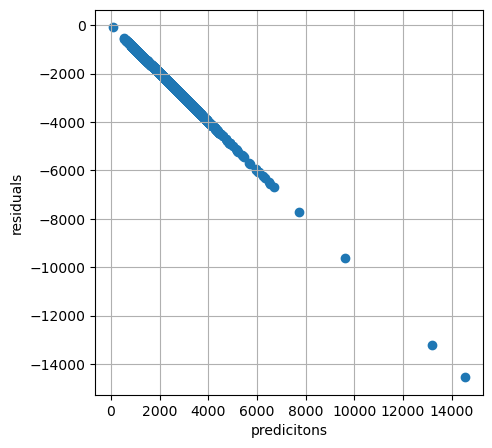

In [49]:
preds = np.exp(best_model.predict(X_valid))
residuals = y_valid - preds
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.scatter(preds, residuals)
ax.grid()
ax.set_xlabel('predicitons')
ax.set_ylabel('residuals')

In [52]:
# Make final predictions
y_pred = best_model.predict(df_working_df_eval.values)
final_preds = np.exp(y_pred)
# Write CSV
id_col = df_eval['id']
new_df = pd.DataFrame(columns=['Id', 'Predicted'])
new_df['Id'] = id_col
new_df['Predicted'] = final_preds
print(new_df.describe())
new_df.to_csv('../output/gradientboost_with_cv_2_todelete.csv', columns=['Id','Predicted'], index=False)

                 Id    Predicted
count   7917.000000  7917.000000
mean   35679.634584  1902.646914
std     2289.051312   749.970003
min    31715.000000   605.443579
25%    33699.000000  1357.192727
50%    35680.000000  1759.885250
75%    37661.000000  2282.973617
max    39643.000000  9517.650162


In [47]:
df_working_df_eval.isna().sum()

timedelta                     0
n_tokens_title                0
n_tokens_content              0
n_unique_tokens               0
num_hrefs                     0
num_self_hrefs                0
num_imgs                      0
num_videos                    0
num_keywords                  0
kw_min_min                    0
kw_max_min                    0
kw_min_max                    0
kw_avg_max                    0
kw_min_avg                    0
kw_max_avg                    0
self_reference_min_shares     0
self_reference_max_shares     0
LDA_01                        0
LDA_02                        0
LDA_03                        0
global_subjectivity           0
global_sentiment_polarity     0
global_rate_positive_words    0
global_rate_negative_words    0
avg_positive_polarity         0
min_positive_polarity         0
max_positive_polarity         0
min_negative_polarity         0
max_negative_polarity         0
title_subjectivity            0
title_sentiment_polarity      0
abs_titl